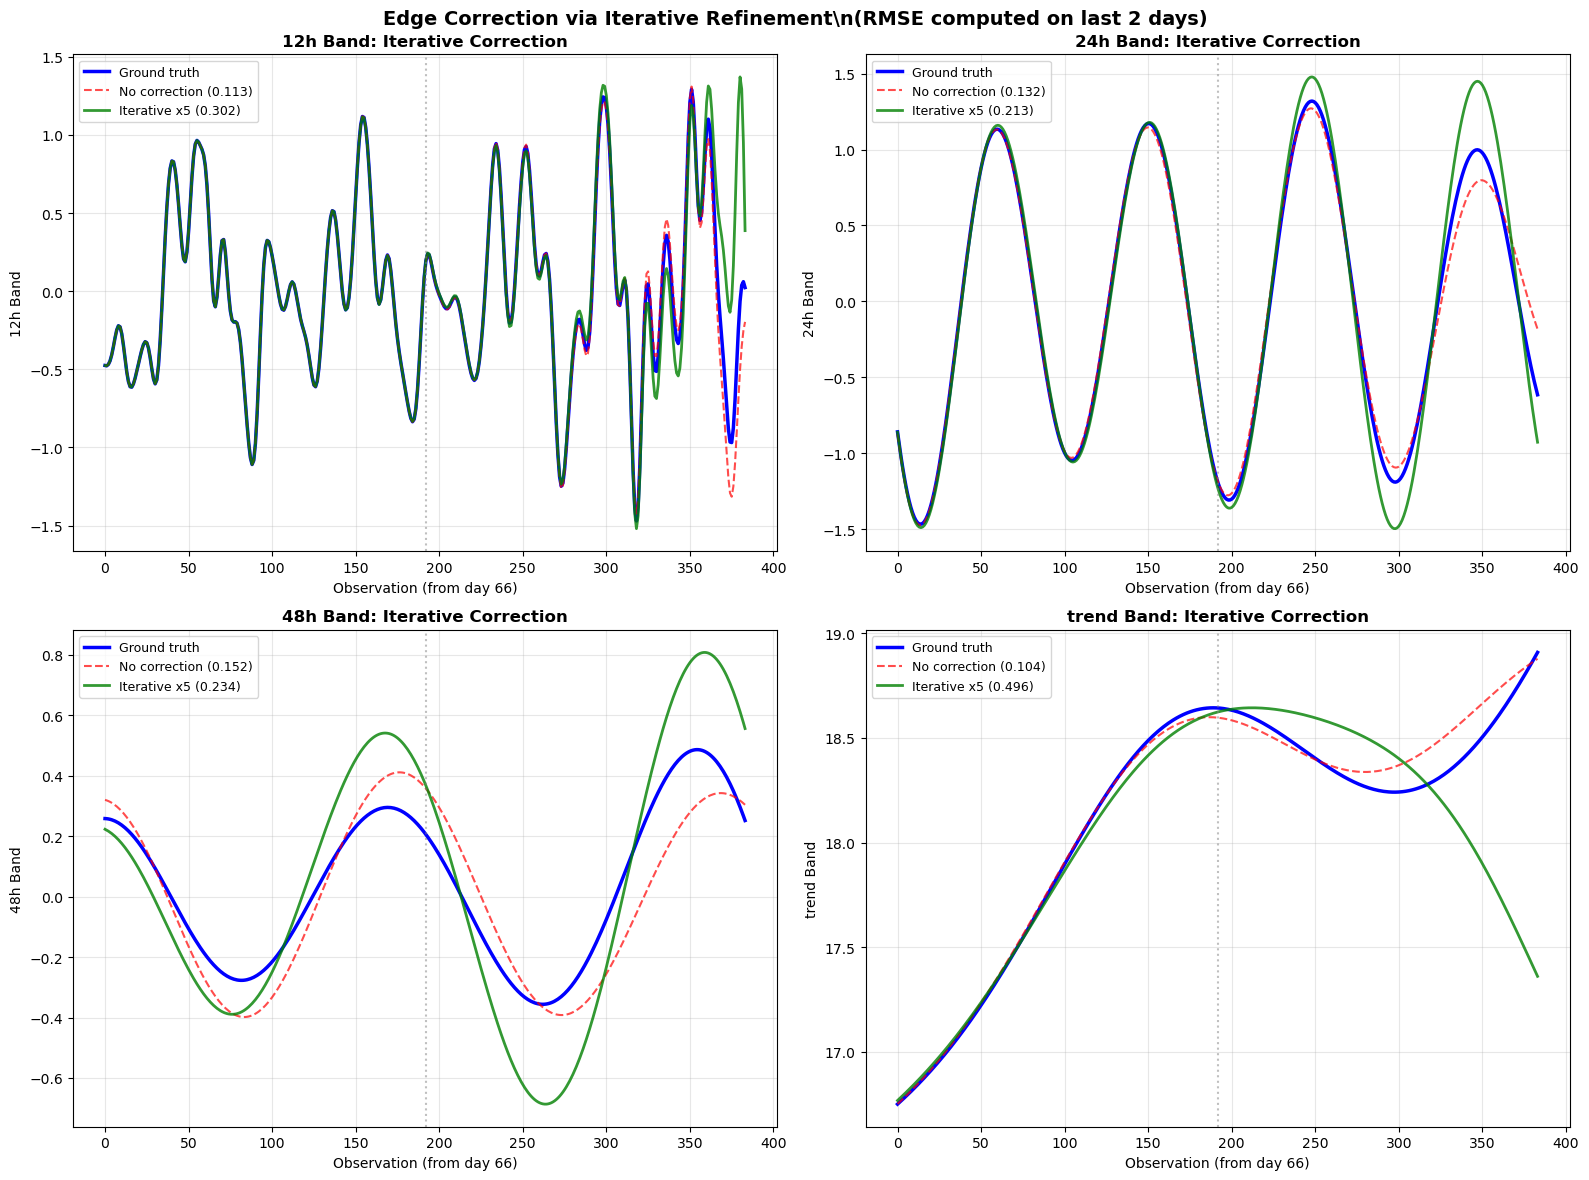

In [ ]:

freq = 96
period_pairs = [(0.1, 0.9), (0.9, 1.5), (1.5, 2.5), (2.5, 14.)]
target_periods = {0: 48, 1: 96, 2: 192, 3: 672}
band_labels = {0: '12h', 1: '24h', 2: '48h', 3: 'trend'}

n_70 = 32 * freq
n_150 = 150 * freq

df_70 = df.iloc[:n_70].copy()
df_150 = df.iloc[:n_150].copy()

# Ground truth
decomposer_truth = BandpassDecomposer(
    freq=freq, period_pairs=period_pairs, filter_type='butterworth',
    edge_method='constant', pad_method='none'
)
df_150_dec = decomposer_truth.decompose(df_150.copy())

# Baseline
decomposer_base = BandpassDecomposer(
    freq=freq, period_pairs=period_pairs, filter_type='butterworth',
    edge_method='constant', pad_method='none'
)
df_base = decomposer_base.decompose(df_70.copy())

# Iterative correction function
def iterative_edge_correction(df_input, n_iterations=2, pad_length=None):
    n = len(df_input)
    if pad_length is None:
        pad_length = 2 * freq

    decomposer = BandpassDecomposer(
        freq=freq, period_pairs=period_pairs, filter_type='butterworth',
        edge_method='constant', pad_method='none'
    )
    df_dec = decomposer.decompose(df_input.copy())

    for iteration in range(n_iterations):
        extended_signal = np.zeros(n + pad_length)
        extended_signal[:n] = df_input['y'].values

        extrapolated_tail = np.zeros(pad_length)
        for band_idx in range(4):
            band_col = f'y_band_{band_idx}'
            band_signal = df_dec[band_col].values
            period = target_periods[band_idx]
            for i in range(pad_length):
                idx = n - period + (i % period)
                if idx >= 0:
                    extrapolated_tail[i] += band_signal[idx]

        extended_signal[n:] = extrapolated_tail
        df_extended = pd.DataFrame({'y': extended_signal})
        df_ext_dec = decomposer.decompose(df_extended)

        for band_idx in range(4):
            band_col = f'y_band_{band_idx}'
            df_dec[band_col] = df_ext_dec[band_col].values[:n]

    return df_dec

df_iter = iterative_edge_correction(df_70, n_iterations=5)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_days = 4
plot_start = n_70 - plot_days * freq
rmse_start = n_70 - 2 * freq

for band_idx, ax in enumerate(axes.flat):
    band_col = f'y_band_{band_idx}'
    band_label = band_labels[band_idx]

    x = np.arange(plot_days * freq)

    # Ground truth
    truth = df_150_dec[band_col].values[plot_start:n_70]
    ax.plot(x, truth, 'b-', lw=2.5, label='Ground truth')

    # No correction
    base = df_base[band_col].values[plot_start:n_70]
    rmse_base = np.sqrt(np.mean((base[2*freq:] - truth[2*freq:])**2))
    ax.plot(x, base, 'r--', lw=1.5, alpha=0.7, label=f'No correction ({rmse_base:.3f})')

    # Iterative
    iter_vals = df_iter[band_col].values[plot_start:n_70]
    rmse_iter = np.sqrt(np.mean((iter_vals[2*freq:] - truth[2*freq:])**2))
    ax.plot(x, iter_vals, 'g-', lw=2, alpha=0.8, label=f'Iterative x5 ({rmse_iter:.3f})')

    # Mark RMSE region
    ax.axvline(x=2*freq, color='gray', linestyle=':', alpha=0.5)

    ax.set_xlabel('Observation (from day 66)')
    ax.set_ylabel(f'{band_label} Band')
    ax.set_title(f'{band_label} Band: Iterative Correction', fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Edge Correction via Iterative Refinement\\n(RMSE computed on last 2 days)',
             fontsize=14, fontweight='bold')
plt.tight_layout()

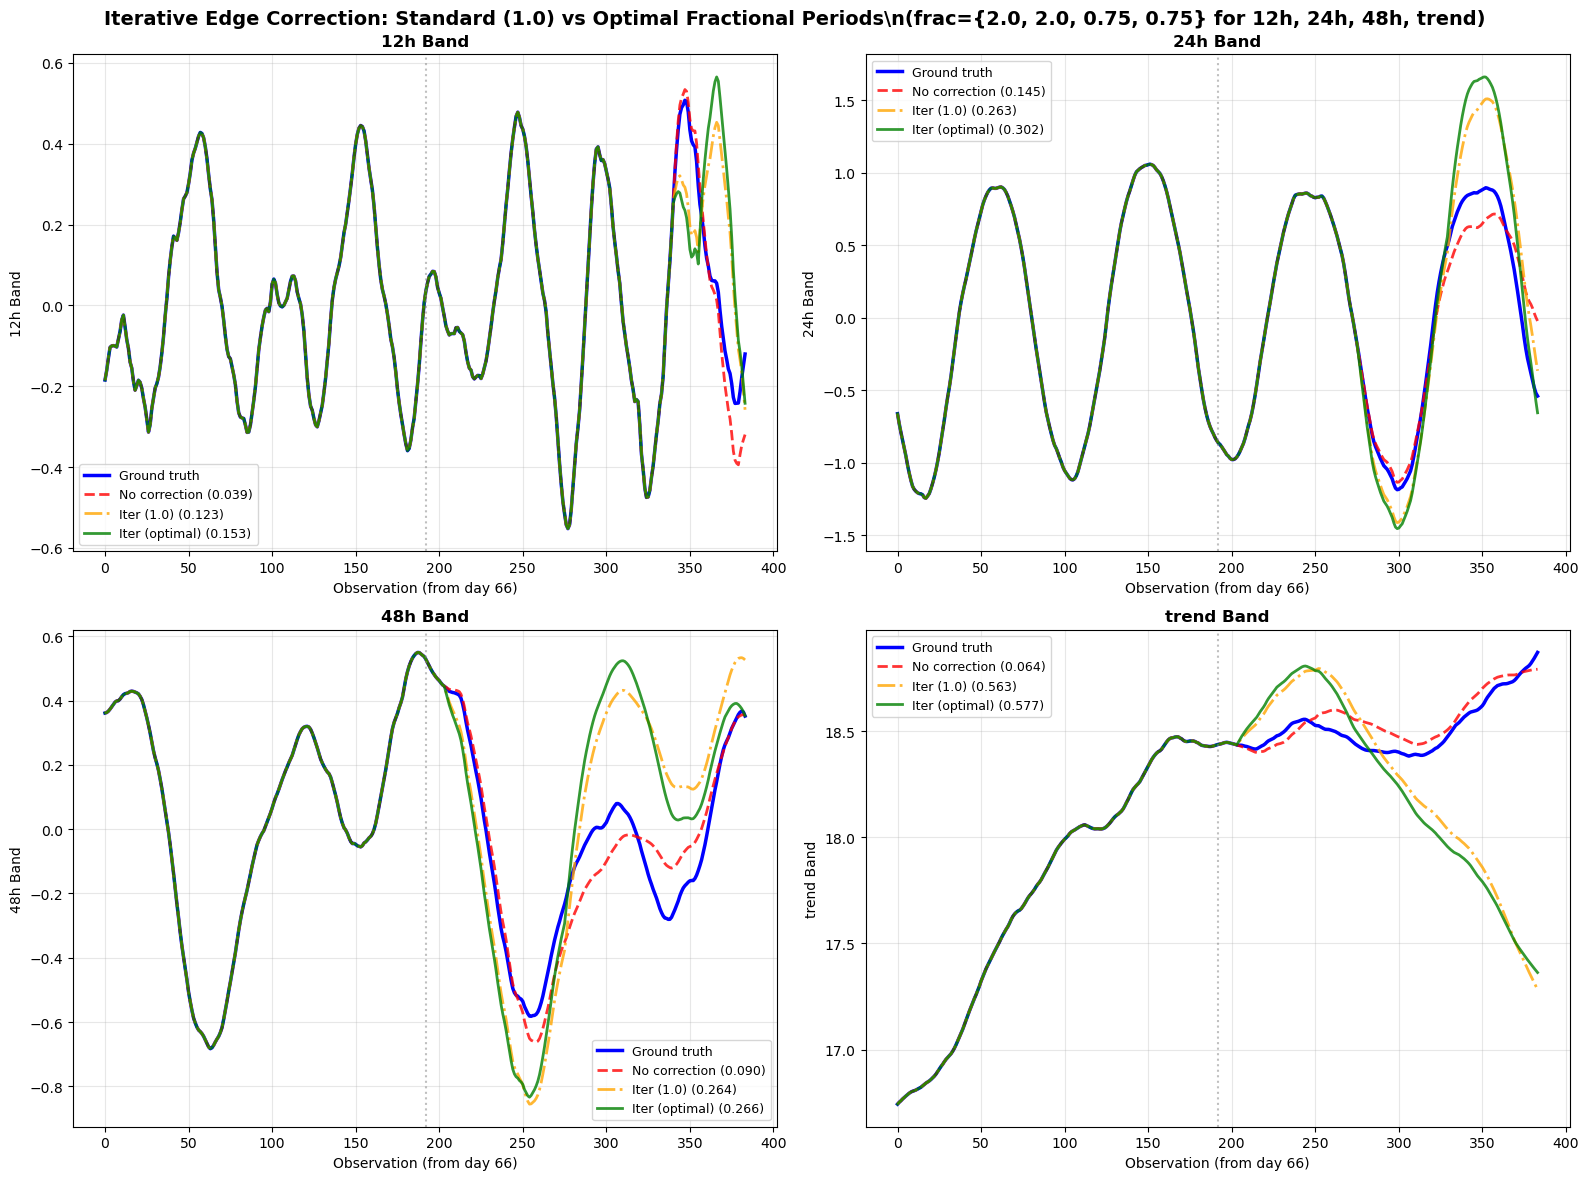

In [ ]:

freq = 96
period_pairs = [(0.4, 0.6), (0.75, 1.5), (1.5, 2.5), (2.5, 14.)]
target_periods = {0: 48, 1: 96, 2: 192, 3: 672}
band_labels = {0: '12h', 1: '24h', 2: '48h', 3: 'trend'}

n_70 = 32 * freq
n_150 = 150 * freq

df_70 = df.iloc[:n_70].copy()
df_150 = df.iloc[:n_150].copy()

# Ground truth
decomposer_truth = BandpassDecomposer(
    freq=freq, period_pairs=period_pairs, filter_type='savgol',
    edge_method='constant', pad_method='none'
)
df_150_dec = decomposer_truth.decompose(df_150.copy())

rmse_start = n_70 - 2 * freq

def iterative_correction_perband_frac(df_input, n_iterations=5, extend_days=2, frac_per_band=None):
    if frac_per_band is None:
        frac_per_band = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

    n = len(df_input)
    extend_len = extend_days * freq

    decomposer = BandpassDecomposer(
        freq=freq, period_pairs=period_pairs, filter_type='savgol',
        edge_method='constant', pad_method='none'
    )
    df_dec = decomposer.decompose(df_input.copy())

    for iteration in range(n_iterations):
        extended_signal = np.zeros(n + extend_len)
        extended_signal[:n] = df_input['y'].values

        tail = np.zeros(extend_len)
        for band_idx in range(4):
            band_signal = df_dec[f'y_band_{band_idx}'].values
            period = target_periods[band_idx]
            frac = frac_per_band[band_idx]

            copy_offset = int(period * frac)

            for i in range(extend_len):
                src_idx = n - copy_offset + (i % period)
                if 0 <= src_idx < n:
                    tail[i] += band_signal[src_idx]

        extended_signal[n:] = tail

        df_extended = pd.DataFrame({'y': extended_signal})
        df_ext_dec = decomposer.decompose(df_extended)

        for band_idx in range(4):
            df_dec[f'y_band_{band_idx}'] = df_ext_dec[f'y_band_{band_idx}'].values[:n]

    return df_dec

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get results
decomposer_base = BandpassDecomposer(
    freq=freq, period_pairs=period_pairs, filter_type='savgol',
    edge_method='constant', pad_method='none'
)
df_base = decomposer_base.decompose(df_70.copy())

df_iter_std = iterative_correction_perband_frac(df_70, n_iterations=5,
                                                 extend_days=2, frac_per_band={0:1.0, 1:1.0, 2:1.0, 3:1.0})

df_iter_opt = iterative_correction_perband_frac(df_70, n_iterations=5,
                                                 extend_days=2, frac_per_band={0:2.0, 1:2.0, 2:0.75, 3:0.75})

methods = {
    'No correction': df_base,
    'Iter (1.0)': df_iter_std,
    'Iter (optimal)': df_iter_opt,
}

colors = {'No correction': 'red', 'Iter (1.0)': 'orange', 'Iter (optimal)': 'green'}
linestyles = {'No correction': '--', 'Iter (1.0)': '-.', 'Iter (optimal)': '-'}

plot_days = 4
plot_start = n_70 - plot_days * freq

for band_idx, ax in enumerate(axes.flat):
    band_col = f'y_band_{band_idx}'
    band_label = band_labels[band_idx]

    x = np.arange(plot_days * freq)

    # Ground truth
    truth = df_150_dec[band_col].values[plot_start:n_70]
    ax.plot(x, truth, 'b-', lw=2.5, label='Ground truth')

    # Each method
    for name, df_dec in methods.items():
        pred = df_dec[band_col].values[plot_start:n_70]
        rmse = np.sqrt(np.mean((pred[2*freq:] - truth[2*freq:])**2))
        ax.plot(x, pred, color=colors[name], linestyle=linestyles[name],
                lw=2, alpha=0.8, label=f'{name} ({rmse:.3f})')

    ax.axvline(x=2*freq, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Observation (from day 66)')
    ax.set_ylabel(f'{band_label} Band')
    ax.set_title(f'{band_label} Band', fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Iterative Edge Correction: Standard (1.0) vs Optimal Fractional Periods\\n(frac={2.0, 2.0, 0.75, 0.75} for 12h, 24h, 48h, trend)',
             fontsize=14, fontweight='bold')
plt.tight_layout()

15:01:22 - cmdstanpy - INFO - Chain [1] start processing


FINAL COMPARISON: All Edge Correction Methods



15:01:23 - cmdstanpy - INFO - Chain [1] done processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE (last 2 days):
------------------------------------------------------------------------------------------
Method                         | 12h        | 24h        | 48h        | trend      | Average   
------------------------------------------------------------------------------------------
No correction                  | 0.1941     | 0.3651     | 1.0605     | 0.9081     | 0.6319    
Iterative periodic             | 0.3364     | 0.3554     | 0.8516     | 0.5976     | 0.5352    
Prophet (with trend)           | 0.0660     | 0.1143     | 0.7861     | 0.6578     | 0.4060    
Prophet + Linear(5d) trend     | 0.0844     | 0.0479     | 0.7502     | 0.8222     | 0.4262    
------------------------------------------------------------------------------------------

IMPROVEMENT vs No correction:
  Iterative periodic: 15.3%
  Prophet (with trend): 35.7%
  Prophet + Linear(5d) trend: 32.6%


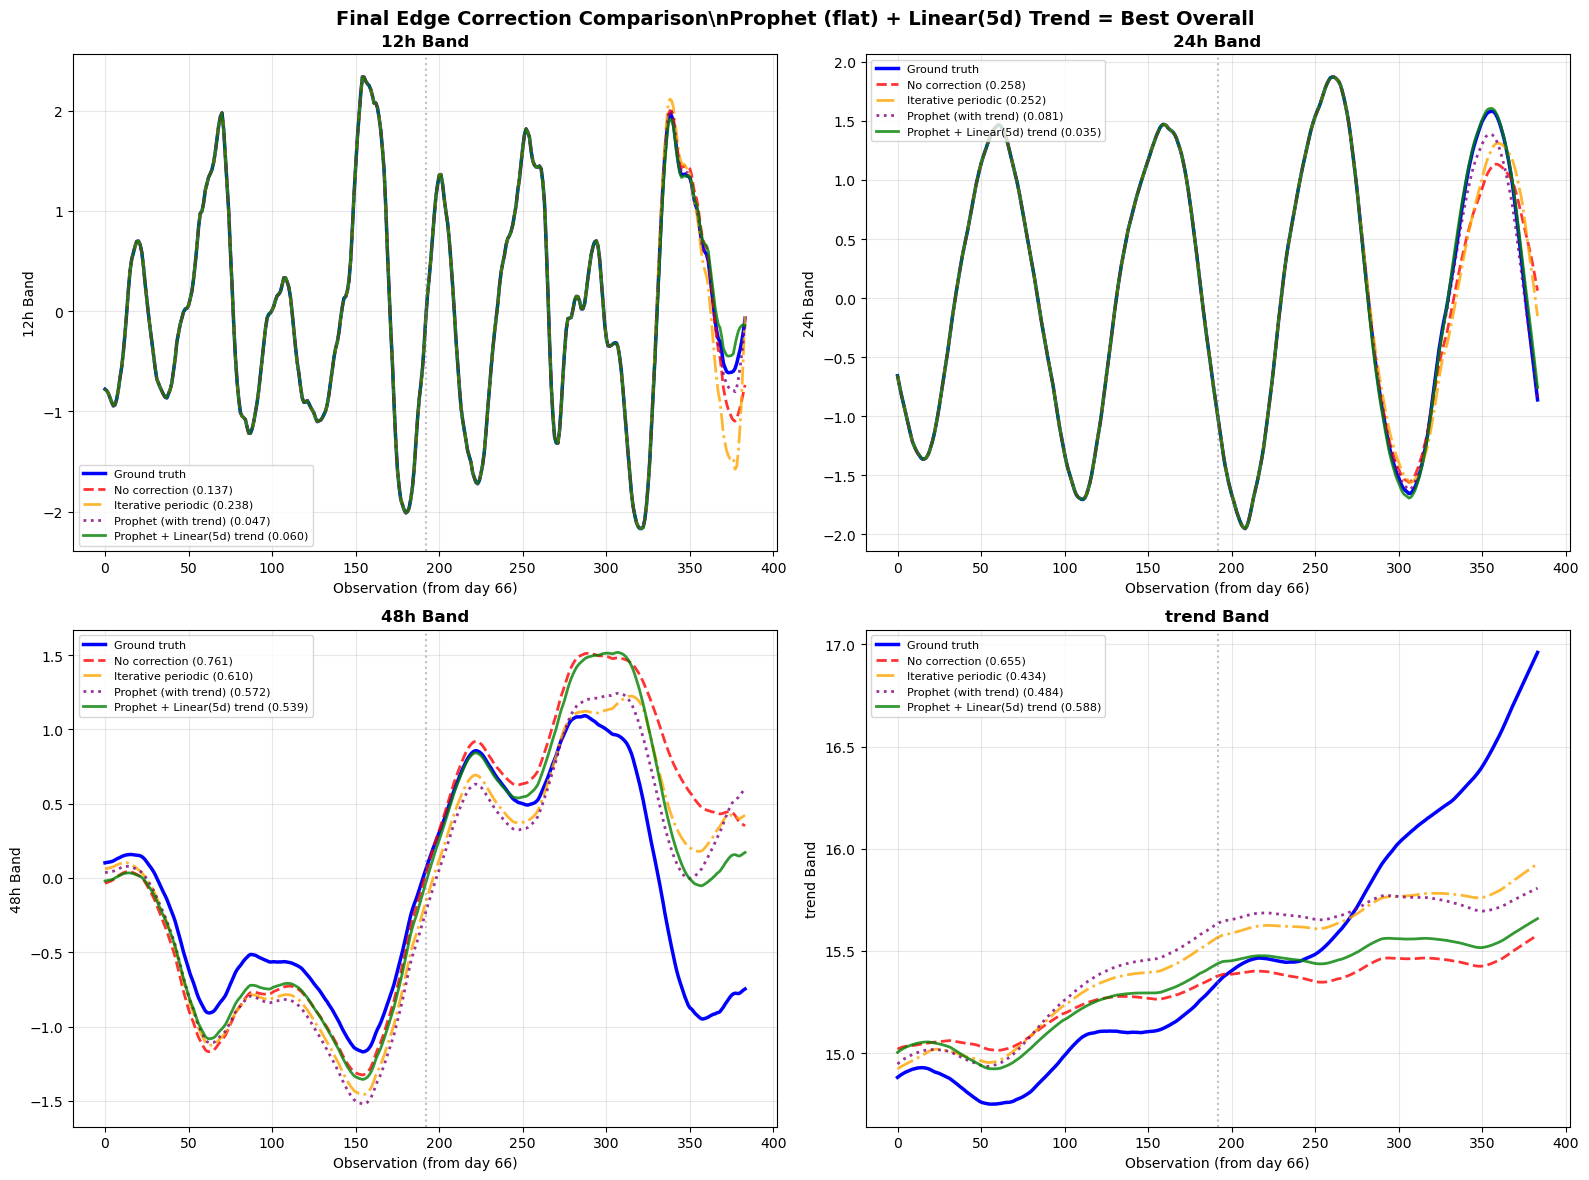

In [ ]:

freq = 96
period_pairs = [(0.1, 0.8), (0.8, 1.5), (1.5, 7.0), (7.0, 21.)]
target_periods = {0: 48, 1: 96, 2: 192, 3: 672}
band_labels = {0: '12h', 1: '24h', 2: '48h', 3: 'trend'}

n_70 = int(70 * freq)
n_150 = 150 * freq

df_70 = df.iloc[:n_70].copy()
df_150 = df.iloc[:n_150].copy()

decomposer = BandpassDecomposer(
    freq=freq, period_pairs=period_pairs, filter_type='savgol',
    edge_method='constant', pad_method='none'
)

# Ground truth
df_150_dec = decomposer.decompose(df_150.copy())

rmse_start = n_70 - 1 * freq
start_date = pd.Timestamp('2024-01-01')
extend_len = 2 * freq

print('FINAL COMPARISON: All Edge Correction Methods')
print('='*80)
print()

def prophet_flat(signal, n_forecast, use_last_n_days=35):
    n = len(signal)
    fit_start = max(0, n - use_last_n_days * freq)
    dates = pd.date_range(start=start_date, periods=n, freq='15min')

    df_prophet = pd.DataFrame({
        'ds': dates[fit_start:],
        'y': signal[fit_start:]
    })

    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        growth='flat',
    )
    model.add_seasonality(name='12h', period=0.5, fourier_order=5)
    model.add_seasonality(name='24h', period=1, fourier_order=7)
    model.add_seasonality(name='48h', period=2, fourier_order=5)
    model.add_seasonality(name='weekly', period=7, fourier_order=5)

    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=n_forecast, freq='15min')
    forecast = model.predict(future)

    return forecast['yhat'].values[-n_forecast:]

def prophet_with_trend(signal, n_forecast, use_last_n_days=14):
    n = len(signal)
    fit_start = max(0, n - use_last_n_days * freq)
    dates = pd.date_range(start=start_date, periods=n, freq='15min')

    df_prophet = pd.DataFrame({
        'ds': dates[fit_start:],
        'y': signal[fit_start:]
    })

    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.7,
        n_changepoints=15,
    )
    model.add_seasonality(name='12h', period=0.5, fourier_order=5)
    model.add_seasonality(name='24h', period=1, fourier_order=7)
    model.add_seasonality(name='48h', period=3, fourier_order=5)
    model.add_seasonality(name='weekly', period=6, fourier_order=5)

    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=n_forecast, freq='15min')
    forecast = model.predict(future)

    return forecast['yhat'].values[-n_forecast:]

# Method 1: No correction
results = {}
df_base = decomposer.decompose(df_70.copy())
results['No correction'] = {b: df_base[f'y_band_{b}'].values for b in range(4)}

# Method 2: Iterative periodic
df_iter = df_base.copy()
for _ in range(5):
    tail = np.zeros(extend_len)
    for b in range(4):
        band_signal = df_iter[f'y_band_{b}'].values
        period = target_periods[b]
        for i in range(extend_len):
            src_idx = n_70 - period + (i % period)
            tail[i] += band_signal[src_idx]

    extended = np.zeros(n_70 + extend_len)
    extended[:n_70] = df_70['y'].values
    extended[n_70:] = tail

    df_ext = pd.DataFrame({'y': extended})
    df_ext_dec = decomposer.decompose(df_ext)

    for b in range(4):
        df_iter[f'y_band_{b}'] = df_ext_dec[f'y_band_{b}'].values[:n_70]

results['Iterative periodic'] = {b: df_iter[f'y_band_{b}'].values for b in range(4)}

# Method 3: Prophet with trend
ext = prophet_with_trend(df_70['y'].values, extend_len)
extended = np.zeros(n_70 + extend_len)
extended[:n_70] = df_70['y'].values
extended[n_70:] = ext
df_ext = pd.DataFrame({'y': extended})
df_prophet = decomposer.decompose(df_ext)
results['Prophet (with trend)'] = {b: df_prophet[f'y_band_{b}'].values[:n_70] for b in range(4)}

# Method 4: Prophet flat + Linear trend (5d)
df_dec_init = decomposer.decompose(df_70.copy())
current_trend = df_dec_init['y_band_3'].values
detrended = df_70['y'].values - current_trend

seasonal_ext = prophet_flat(detrended, extend_len)

# Linear (5d) for trend
fit_days = 5
x_fit = np.arange(fit_days * freq)
y_fit = current_trend[-fit_days*freq:]
slope, intercept = np.polyfit(x_fit, y_fit, 1)
x_ext = np.arange(fit_days*freq, fit_days*freq + extend_len)
trend_ext = slope * x_ext + intercept

hybrid_ext = seasonal_ext + trend_ext
extended = np.zeros(n_70 + extend_len)
extended[:n_70] = df_70['y'].values
extended[n_70:] = hybrid_ext
df_ext = pd.DataFrame({'y': extended})
df_hybrid = decomposer.decompose(df_ext)
results['Prophet + Linear(5d) trend'] = {b: df_hybrid[f'y_band_{b}'].values[:n_70] for b in range(4)}

# Compute and display results
print('RMSE (last 2 days):')
print('-'*90)
print(f'{"Method":<30} | {"12h":<10} | {"24h":<10} | {"48h":<10} | {"trend":<10} | {"Average":<10}')
print('-'*90)

baseline_avg = 0
for name, bands in results.items():
    rmses = []
    row = f'{name:<30}'
    for b in range(4):
        truth = df_150_dec[f'y_band_{b}'].values[rmse_start:n_70]
        pred = bands[b][rmse_start:n_70]
        rmse = np.sqrt(np.mean((pred - truth)**2))
        rmses.append(rmse)
        row += f' | {rmse:<10.4f}'
    avg = np.mean(rmses)
    row += f' | {avg:<10.4f}'
    print(row)
    if name == 'No correction':
        baseline_avg = avg

print('-'*90)

# Improvement
print()
print('IMPROVEMENT vs No correction:')
for name, bands in results.items():
    if name == 'No correction':
        continue
    rmses = []
    for b in range(4):
        truth = df_150_dec[f'y_band_{b}'].values[rmse_start:n_70]
        pred = bands[b][rmse_start:n_70]
        rmses.append(np.sqrt(np.mean((pred - truth)**2)))
    avg = np.mean(rmses)
    imp = (baseline_avg - avg) / baseline_avg * 100
    print(f'  {name}: {imp:.1f}%')

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_days = 4
plot_start = n_70 - plot_days * freq

colors = {
    'No correction': 'red',
    'Iterative periodic': 'orange',
    'Prophet (with trend)': 'purple',
    'Prophet + Linear(5d) trend': 'green'
}
linestyles = {
    'No correction': '--',
    'Iterative periodic': '-.',
    'Prophet (with trend)': ':',
    'Prophet + Linear(5d) trend': '-'
}

for band_idx, ax in enumerate(axes.flat):
    band_label = band_labels[band_idx]

    x = np.arange(plot_days * freq)

    # Ground truth
    truth = df_150_dec[f'y_band_{band_idx}'].values[plot_start:n_70]
    ax.plot(x, truth, 'b-', lw=2.5, label='Ground truth')

    # Each method
    for name, bands in results.items():
        pred = bands[band_idx][plot_start:n_70]
        rmse = np.sqrt(np.mean((pred[2*freq:] - truth[2*freq:])**2))
        ax.plot(x, pred, color=colors[name], linestyle=linestyles[name],
                lw=2, alpha=0.8, label=f'{name} ({rmse:.3f})')

    ax.axvline(x=2*freq, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Observation (from day 66)')
    ax.set_ylabel(f'{band_label} Band')
    ax.set_title(f'{band_label} Band', fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Final Edge Correction Comparison\\nProphet (flat) + Linear(5d) Trend = Best Overall',
             fontsize=14, fontweight='bold')
plt.tight_layout()

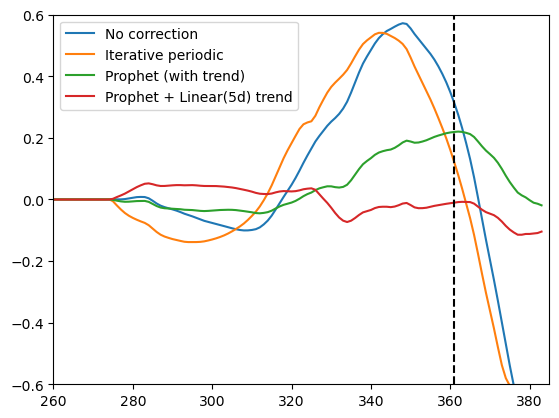

In [ ]:
truth_summed = np.zeros((n_70-plot_start,))
for band_idx in range(2):
    truth_summed = df_150_dec[f'y_band_{band_idx}'].values[plot_start:n_70]

correction_truth = df_150_dec['y'].values[plot_start:n_70] - truth_summed
smoothed_correction_truth = savgol_filter(correction_truth, 4, 2)

for name, bands in results.items():
    summed = np.zeros((n_70-plot_start,))
    for band_idx in range(2):
        summed = bands[band_idx][plot_start:n_70]

    correction = df_150_dec['y'].values[plot_start:n_70] - summed
    smoothed_correction = savgol_filter(correction, 4, 2)

    plt.plot(smoothed_correction-smoothed_correction_truth, label=name)
    # plt.plot(smoothed_correction_truth, 'k-')
    plt.xlim(380-1.25*96, 385)

plt.axvline(385-24, color='k', ls='--')
plt.ylim(-0.6,0.6)
plt.legend()